The following code demonstrates the [StandardImportToolPlugin](https://github.com/cat-cfs/StandardImportToolPlugin).  The simulation definition is built using the SITConfig helper class, and then imported via the Operational-Scale CBM-CFS3 standard import tool.  

The simulation is a replica of the CBM3 Tutorial1 afforestation project.  This tutorial can be found in your toolbox installation directory which is by default at this directory:

`C:\Program Files (x86)\Operational-Scale CBM-CFS3\Tutorials\Tutorial 1`


In [1]:
import sys, os, json, subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

The following imports are used to load:
 1. The standard import tool plugin, which acts as an interface between python and your installed copy of the Operational-Scale CBM-CFS3 toolbox
 2. The cbm3_python package, which helps with automation of CBM3 simulation, CBM3 data management and and results analysis.

In [2]:
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()

The next lines build a configuration for importing a CBM3 project using python code.  The paths to the project database, the results database and the initial project specification are set here.

Note the variables `c`, `project_path`, `results_db_path`, `config_save_path` which are re-used for later steps

In [3]:
cwd = os.getcwd()
print(cwd)

C:\PySIT\cbm3_scripting_examples


In [4]:
project_path = r".\Test_Ont\Test_Ont2.mdb"
results_db_path = r".\Test_Ont\Test_Ont_Results.mdb"
config_save_path = r'C:\PySIT\Test2.json'
sit_db_path = r'C:\PySIT\Test_Ont_SIT.mdb'
age_class_size = 5
num_age_classes = 36
classifiers = {'Subunit', 'Forest Unit', 'Species'}


c = sit_helper.SITConfig(
    imported_project_path=project_path,
    initialize_mapping=True
)
c.database_path(sit_db_path, 'SIT_Ageclasses', 'SIT_Classifiers',
        'SIT_Events', 'SIT_DistTypes',
        'SIT_Inventory', 'SIT_Transitions', 'SIT_Yields')

#c.data_config(age_class_size, num_age_classes, ('Subunit', 'Forest Unit', 'Species'))


c.set_species_classifier("Species")
c.set_single_spatial_unit(17)

c.map_species('SI1', 'Black spruce')
c.map_species('SI2', 'Black spruce')
c.map_species('SI3', 'Black spruce')
c.map_species('SI4', 'Black spruce')

c.map_disturbance_type('1', 'Wild Fire')
c.map_disturbance_type('2', 'Clearcut harvesting with salvage')


c.save(config_save_path)



In [5]:
print(config_save_path)

C:\PySIT\Test2.json


In [6]:
c.import_project(standard_import_tool_plugin_path, config_save_path)

In [7]:
cbm3_python_dir = os.path.abspath(os.path.join(".","cbm3_python"))
if not cbm3_python_dir in sys.path:
    sys.path.append(os.path.abspath(cbm3_python_dir))

In [8]:
import cbm3_python.simulation.projectsimulator

In [9]:
def copy_database_local(network_path, local_path): 
    if os.path.exists(local_path):
        os.remove(local_path)
       
    shutil.copy(network_path, local_path)

RUN THE PROJECT

In [10]:
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
project_root = r'C:\PySIT\cbm3_scripting_examples\Test_Ont'

projects = {
    "Ont": os.path.join(project_root, "Test_Ont2.mdb")
    }       

results = {
   "Ont": os.path.join(project_root, 'Results','Test_Ont2_Results.mdb')
    }       

cbm_exe_path = r'\\dstore.pfc.forestry.ca\carbon1\CBM Tools and Development\Builds\CBMBuilds\20181109_extended_kf5_passive_rule'

#aidb_path_network = r'\\dstore.pfc.forestry.ca\carbon1\NIR_2020\03_Analysis\01_CBM\02_Production\03_LastPassDisturbance\02_SupplementaryData\ArchiveIndex_NIR2020_LastPass.mdb'
aidb_path = r'C:\Last_Pass\Makelist_Dist_Fixes\Projects\AIDB\ArchiveIndex_NIR2020_LastPass.mdb'

#copy_database_local(aidb_path_network, aidb_path)

dist_classes_path  = r'C:\NIR_Workspace\Run_CBM_Python\99b_disturbance_classes.csv'
dist_rules_path = r'C:\NIR_Workspace\Run_CBM_Python\99a_disturbance_rules.csv'
skip_makelist=False   #RUN MAKELIST
use_existing_makelist_output=False

#set this to a file to print cbm stdout to file
stdout_path=r"./cbm_stdout.txt"

In [11]:
for project_code, project_path in projects.items():  

    results_db_path = cbm3_python.simulation.projectsimulator.run(
        aidb_path=aidb_path, 
        project_path=project_path, 
        toolbox_installation_dir=toolbox_path,
        cbm_exe_path=cbm_exe_path,
        results_database_path= results[project_code],
        skip_makelist=skip_makelist,
        copy_makelist_results = True,
        use_existing_makelist_output=use_existing_makelist_output,
        stdout_path= os.path.join(os.path.dirname(project_path), 'cbm_stdout_{}.txt'.format(project_code)), 
        dist_classes_path=dist_classes_path,
        dist_rules_path=dist_rules_path,
        tempfiles_output_dir = os.path.join(os.path.dirname(results[project_code]), 'temp'))

In [21]:
import os, sys, pyodbc, shutil, pandas as pd, numpy as np 
from pandas import DataFrame as DF
import matplotlib.pyplot as plt
%matplotlib inline



cbm3_python_dir = os.path.abspath(os.path.join(".","cbm3_python"))
if not cbm3_python_dir in sys.path:
    sys.path.append(os.path.abspath(cbm3_python_dir))
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data import results_queries
suffixes=('_NewCBM', '_LastPass')
#suffixes=('_Ontario', '_Ontario')


In [13]:
def get_cursor(path):
    return pyodbc.connect(
        "DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={}".format(path)
    ).cursor()    

baseyear = 1990
results_db = get_cursor(results['Ont'])


In [16]:
pool_indicators = cbm3_results.load_pool_indicators(results_db_path, land_class_grouping=True)
#pool_indicators2 = cbm3_results.load_pool_indicators(results_db_path2, land_class_grouping=True)

flux_indicators = cbm3_results.load_stock_changes(results_db_path, land_class_grouping=True)
#flux_indicators2 = cbm3_results.load_stock_changes(results_db_path2, land_class_grouping=True)

dist_indicators = cbm3_results.load_disturbance_indicators(results_db_path, disturbance_type_grouping=True, land_class_grouping=True)
#dist_indicators2 = cbm3_results.load_disturbance_indicators(results_db_path2, disturbance_type_grouping=True, land_class_grouping=True)

#age_indicators = cbm3_results.load_disturbance_indicators(results_db_path, land_class_grouping=True)

In [17]:
pool_indicators_filtered = pool_indicators.loc[pool_indicators["LandClassID"]==0]
pool_indicators_filtered2 = pool_indicators.loc[pool_indicators["LandClassID"]==0]

colnames = ["TimeStep",
    "Belowground Biomass",
    "Aboveground Biomass",
    "Deadwood",
     "Litter",
     "Soil C"]

df_a = pool_indicators_filtered[colnames].groupby("TimeStep").sum()
df_b = pool_indicators_filtered2[colnames].groupby("TimeStep").sum()

df_rel_dif = ((df_a-df_b)/(df_a + df_b)/2).abs()
df_dif = (df_a-df_b)


dfaa = df_a.merge(df_b, left_on='TimeStep', right_on='TimeStep', suffixes=suffixes)


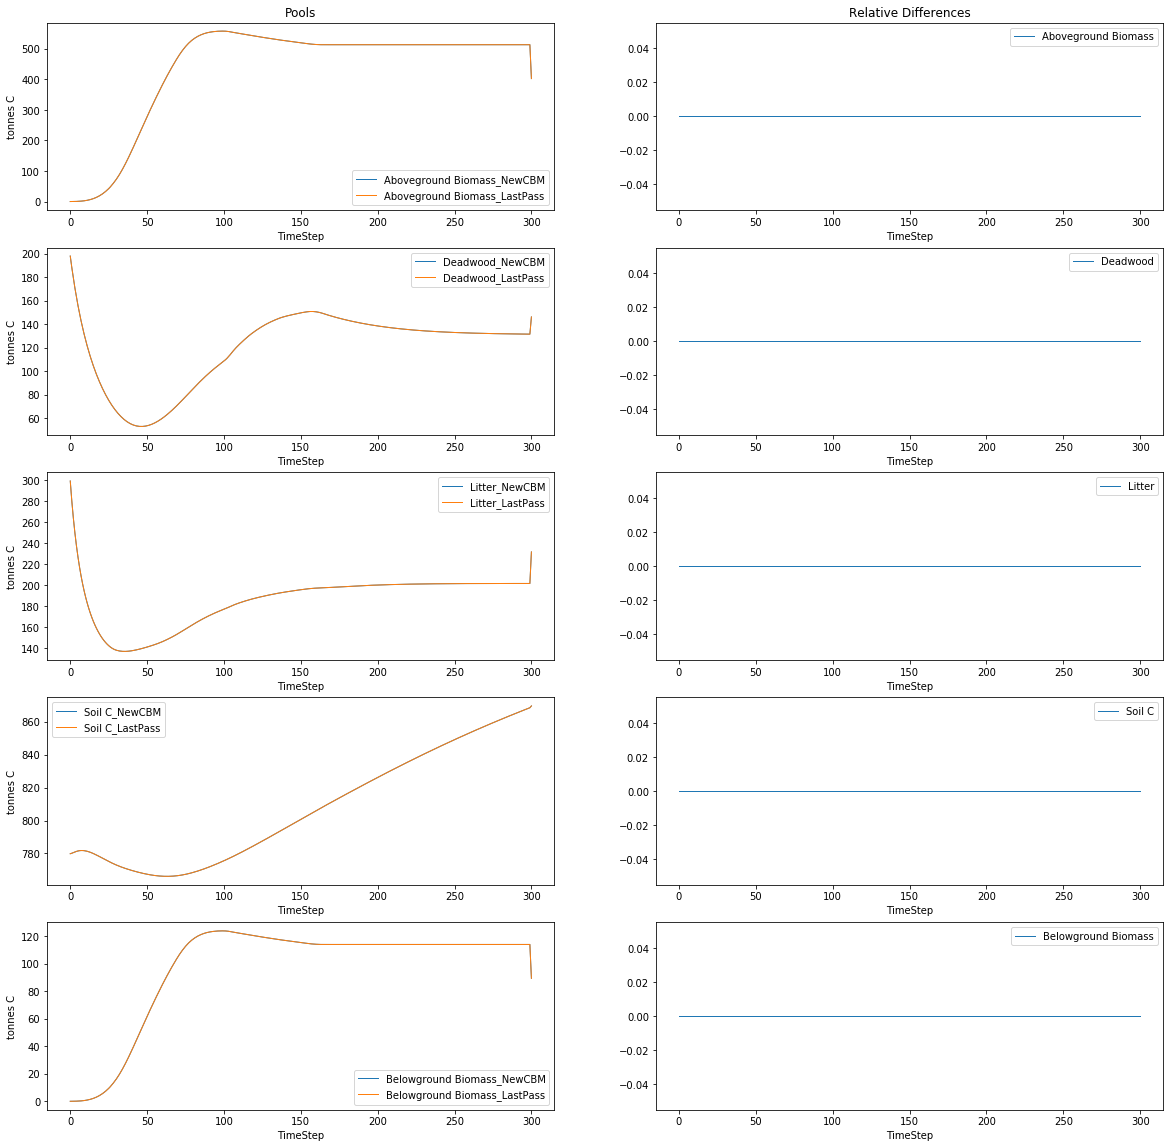

In [22]:
nrows = len(colnames) - 1
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.monospace'] 
fig, axes = plt.subplots(nrows=nrows, ncols=2,figsize=(20, 20))
for x in range(nrows):
    axes[x, 0].set_ylabel('tonnes C')
    
axes[0, 0].set_title('Pools')
axes[0, 1].set_title('Relative Differences')

for x in range(nrows):
    dfaa[[colnames[x+1]+suffixes[0], colnames[x+1]+suffixes[1]]].plot(ax=axes[x-1, 0])
    df_rel_dif[[colnames[x+1]]].plot(ax=axes[x-1, 1])

plt.savefig("QAQC_Last_Pass_Checks.png", dpi=600)
